In [1]:
##Import
import cv2
import pandas as pd
import numpy as np
import random
#import pickle
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda, ELU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import model_from_json
import json
import csv
%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


Data Shape:  (8036, 7)
non zero Data Shape:  (3675, 7)
zero Data Shape:  (480, 7)
new Data Shape:  (4155, 7)
We have  124  differnt angles

Angles Distribtion of all Data


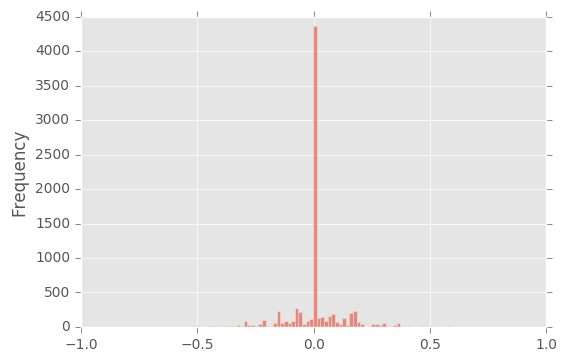

In [2]:
##Load data

col_names = ['center', 'left','right','steering','throttle','brake','speed']
traindata = pd.read_csv("data/driving_log.csv",names=col_names)
train_nonzero = traindata[traindata.steering != 0]
train_zero = (traindata[traindata.steering == 0]).sample(frac=.11)
print("Data Shape: ",traindata.shape)
print("non zero Data Shape: ",train_nonzero.shape)
print("zero Data Shape: ",train_zero.shape)

data_train = pd.concat([train_nonzero, train_zero], ignore_index=True)




print("new Data Shape: ",data_train.shape)
print("We have ",len(data_train.steering.unique()), " differnt angles")
print()
print("Angles Distribtion of all Data")
traindata.steering.plot.hist(bins=124,alpha=0.6)

Angles Distribtion after take 11% of zero angles data only


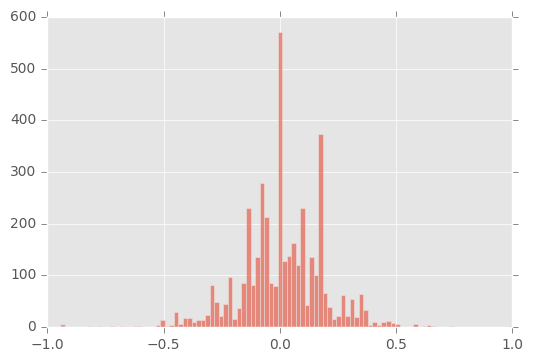

In [3]:
print("Angles Distribtion after take 11% of zero angles data only")
data_train.steering.hist(bins=100,alpha = 0.6)


In [4]:
## create adjusted steering angles for the side camera images
correction = 0.05 #0.25  #0.03 #0.05 this is a parameter to tune
steering_left = data_train.steering + correction
steering_right = data_train.steering - correction

print(data_train.steering[0:3])
print(steering_left[0:3])

0    0.061760
1    0.052191
2    0.052191
Name: steering, dtype: float64
0    0.111760
1    0.102191
2    0.102191
Name: steering, dtype: float64


In [5]:
##views from data
center = data_train['center']
left  = data_train['left']
right = data_train['right']
steering_center = data_train['steering']
print(" view from img center : ",center.head(3))
print(" view from img center : ",left.head(3))
print(" view from img center : ",right.head(3))
print(" view from steering center : ",steering_center.head(3))
print(" view from steering center : ",steering_left.head(3))
print(" view from steering center : ",steering_right.head(3))


 view from img center :  0    IMG/center_2016_12_01_13_32_43_457.jpg
1    IMG/center_2016_12_01_13_32_43_558.jpg
2    IMG/center_2016_12_01_13_32_43_659.jpg
Name: center, dtype: object
 view from img center :  0     IMG/left_2016_12_01_13_32_43_457.jpg
1     IMG/left_2016_12_01_13_32_43_558.jpg
2     IMG/left_2016_12_01_13_32_43_659.jpg
Name: left, dtype: object
 view from img center :  0     IMG/right_2016_12_01_13_32_43_457.jpg
1     IMG/right_2016_12_01_13_32_43_558.jpg
2     IMG/right_2016_12_01_13_32_43_659.jpg
Name: right, dtype: object
 view from steering center :  0    0.061760
1    0.052191
2    0.052191
Name: steering, dtype: float64
 view from steering center :  0    0.111760
1    0.102191
2    0.102191
Name: steering, dtype: float64
 view from steering center :  0    0.011760
1    0.002191
2    0.002191
Name: steering, dtype: float64


In [6]:
##Create X ,Y (img,steering)
img = pd.concat([center, left, right], ignore_index=True)
steering = pd.concat([steering_center, steering_left,steering_right ], ignore_index=True)

print("view from img",img.head(3) )
print("view from steering",steering.head(3) )
print("img Shape",img.shape)
print("steering Shape",steering.shape)

view from img 0    IMG/center_2016_12_01_13_32_43_457.jpg
1    IMG/center_2016_12_01_13_32_43_558.jpg
2    IMG/center_2016_12_01_13_32_43_659.jpg
dtype: object
view from steering 0    0.061760
1    0.052191
2    0.052191
Name: steering, dtype: float64
img Shape (12465,)
steering Shape (12465,)


In [7]:
##split (train set and validation set) ,Shuffle train se) and form sets to array
#split
timg, vimg, tsteering, vsteering = train_test_split(img, steering, test_size=0.1, random_state=42)


#shuffle
timg, tsteering = shuffle(timg, tsteering)

#as array
timg = np.array(timg)
vimg = np.array(vimg)
tsteering = np.array(tsteering)
vsteering = np.array(vsteering)

print("Train img Shape",timg.shape)
print("train steering Shape",tsteering.shape)
print("validation img Shape",vimg.shape)
print("validation steering Shape",vsteering.shape)

Train img Shape (11218,)
train steering Shape (11218,)
validation img Shape (1247,)
validation steering Shape (1247,)


In [8]:
##Preprocess Functions
"""
Preprocss functions 
1- cropresize(img): 
Crop non important parts from an image (img) and retain only the track, Then Resize the image to 64*64 dimensions 

2- change_colorspace(img, color_space='RGB'):
change from RGB mode to YUV

3- flipped_image(img, steering):
flip image (img) horizontally then reverse the steering angle (steering)

4-brightnessed_image(img):
set random brightness to the image (img)

5- translated_image(img, steering):
to generate fair dataset (normal distrebution) generate a new image 
from the current image(img) using random shift in horizontal direction. 
with change in the steering angle (steering) value is 0.4 per pixel

6- image_augmentation(img, steering):
apply flipped_image with 50% chance then apply Brightness and tranlslate functions 
""" 
#cropresize
def cropresize(img):  
    # crop non important parts and retain only the track
    roi = img[60:140, :, :]
    
    # Resize the image
    resize = cv2.resize(roi, (64, 64), interpolation=cv2.INTER_AREA)
    return resize

def change_colorspace(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img = np.copy(img)
    return img
    

def flipped_image(img, steering):
    img = cv2.flip(img, 1)
    return img, -steering


def brightnessed_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = 0.8 + 0.4*(2*np.random.uniform()-1.0)    
    img[:,:,2] = img[:,:,2]*random_bright
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img


def translated_image(img, steering):
    rows, cols, _ = img.shape
    tr_x = 100 * np.random.uniform() - 100/2
    steering = steering + tr_x/100 * 2 *.4
    tr_y = 10 * np.random.uniform() - 10/2
    Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    return img, steering


def image_augmentation(img, steering):
    if np.random.uniform() < 0.5:
        img, steering = flipped_image(img, steering)
    img = brightnessed_image(img)
    img, steering = translated_image(img, steering)
    return img, steering





############################################################################

##Process  (read + augmentation + transform to 64*64)
#Process Train img 
def readTrainimage(img,steering):
    # Let's read the image
    folderpath = "data/"
    img = cv2.imread(folderpath+img.strip(' '))  # Read in the image
    img, steering = image_augmentation(img, steering) 
    img = cropresize(img)  # Crop and resize the image
    # change colorspace:
    img = change_colorspace(img, color_space='YUV')
    return img, steering

#Process Valid img
def readValidimage(img,steering):
    # Let's read the image
    folderpath = "data/"
    img = cv2.imread(folderpath+img.strip(' '))  # Read in the image
    img = cropresize(img)  # Crop and resize the image
    # change colorspace:
    img = change_colorspace(img, color_space='YUV')
    return img, steering

In [9]:
##Generate  samples from training and validation sets
#for train set
def traingenerator(img, steering, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            #choose random index in features
            index = np.random.randint(0, len(img))
            batch_features[i], batch_labels[i] = readTrainimage(img[index],steering[index]) 
        yield batch_features, batch_labels

#for validset        
def Validgenerator(img, steering, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            #choose random index in features
            index= np.random.randint(0,len(img))
            batch_features[i], batch_labels[i] =readValidimage(img[index],steering[index]) 
        yield batch_features, batch_labels



In [ ]:
##Test/Demo

index = np.random.randint(0, len(timg))
print(index)
batch_features, batch_labels = readTrainimage(timg[index], steering[index]) 
print('Returned batch size: {}'.format(len(batch_features))) 
print('Returned image shape: {}'.format(batch_features[0].shape))
plt.imshow(batch_features)
plt.axis('off')
plt.show()


In [11]:
##define model
input_shape = (64, 64, 3)
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    model.compile(optimizer="adam", loss="mse")
    return model

In [12]:
##Train
model = get_model()
history_object= model.fit_generator(
    traingenerator(timg, tsteering, 32),
    samples_per_epoch=20000,
    nb_epoch=10,
    validation_data=Validgenerator(vimg, vsteering, 250),
    nb_val_samples=1280,
    callbacks=[ModelCheckpoint(filepath="v2model.h5", verbose=1, save_best_only=True)])

Epoch 1/10
20000/20000 [==============================] - 55s - loss: 2.7226 - val_loss: 0.1127
Epoch 2/10
20000/20000 [==============================] - 51s - loss: 0.6659 - val_loss: 0.0429
Epoch 3/10
20000/20000 [==============================] - 50s - loss: 0.2847 - val_loss: 0.0327
Epoch 4/10
20000/20000 [==============================] - 51s - loss: 0.1301 - val_loss: 0.0282
Epoch 5/10
20000/20000 [==============================] - 52s - loss: 0.0688 - val_loss: 0.0231
Epoch 6/10
20000/20000 [==============================] - 53s - loss: 0.0444 - val_loss: 0.0193
Epoch 7/10
20000/20000 [==============================] - 54s - loss: 0.0364 - val_loss: 0.0231
Epoch 8/10
20000/20000 [==============================] - 53s - loss: 0.0325 - val_loss: 0.0200
Epoch 9/10
20000/20000 [==============================] - 53s - loss: 0.0312 - val_loss: 0.0199
Epoch 10/10
20000/20000 [==============================] - 56s - loss: 0.0298 - val_loss: 0.0195


In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv0 (Convolution2D)            (None, 64, 64, 3)     12          lambda_1[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 62, 62, 32)    896         conv0[0][0]                      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 62, 62, 32)    0           conv1[0][0]                      
___________________________________________________________________________________________

dict_keys(['loss', 'val_loss'])


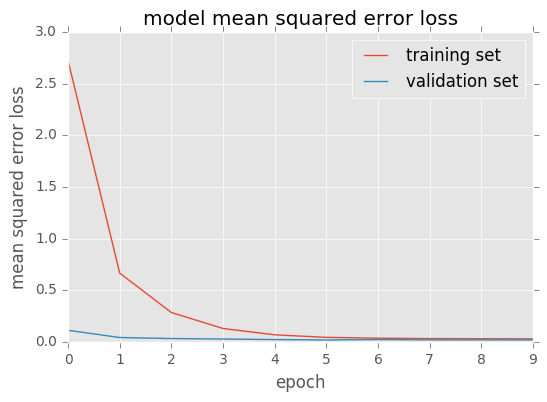

In [15]:
##visualize loss
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()